# 04-3 RoBERTa와 DistilBERT

*이 노트북은 코랩의 A100 GPU 런타임으로 테스트했습니다.*

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hm-dl/blob/main/04-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

04-1절에서 정의한 `transformer_encoder()` 함수를 재사용합니다.

In [ ]:
# x는 토큰 임베딩과 위치 임베딩을 더한 값입니다.
def transformer_encoder(x, padding_mask, dropout, activation='relu'):
    residual = x
    key_dim = embed_dim // num_heads
    # 멀티 헤드 어텐션을 통과합니다.
    x = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout)(
        query=x, value=x, attention_mask=padding_mask)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    residual = x
    # 위치별 피드 포워드 네트워크
    x = layers.Dense(embed_dim * 4, activation=activation)(x)
    x = layers.Dense(embed_dim)(x)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    return x

## RoBERTa

In [3]:
!pip install keras-nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.2/572.2 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 103.7 MB/s eta 0:00:00


In [10]:
import keras
from keras import layers
import keras_nlp

# RoBERTa 백본
vocab_size = 50265
num_layers = 12
num_heads = 12
embed_dim = 768
dropout = 0.1
activation = 'gelu'
max_seq_len = 512

token_ids = keras.Input(shape=(None,))
padding_mask = keras.Input(shape=(None,))

token_embedding = layers.Embedding(vocab_size, embed_dim)(token_ids)
pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)

x = layers.Add()((token_embedding, pos_embedding))
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout)(x)

for _ in range(num_layers):
   x = transformer_encoder(x, padding_mask, dropout, activation)

outputs = x
roberta_model = keras.Model(inputs=(token_ids, padding_mask),
                            outputs=(outputs))
roberta_model.summary()

NameError: name 'transformer_encoder' is not defined

In [ ]:
roberta_classifier = keras_nlp.models.RobertaClassifier.from_preset(
    "roberta_base_en",
    num_classes=1,
    activation='sigmoid'
)
roberta_classifier.summary()

Preprocessor: "roberta_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ roberta_tokenizer (RobertaTokenizer)               │                                              50,265 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "roberta_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ roberta_backbone              │ (None, None, 768)         │     124,052,736 │ padding_mask[0][0],        │
│ (RobertaBackbone)             │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ roberta_backbone[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dropout (Dropout)      │ (None, 768)               │               0 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ pooled_dropout[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 1)                 │             769 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 124,644,097 (475.48 MB)

 Trainable params: 124,644,097 (475.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
roberta_tokenizer = roberta_classifier.preprocessor.tokenizer

In [ ]:
token_ids = roberta_tokenizer.tokenize('"pandemonium" is a horror movie')
for id in token_ids:
    print(roberta_tokenizer.id_to_token(id), end=' ')

" p and emonium " Ġis Ġa Ġhorror Ġmovie 

## IMDB 데이터셋으로 RoBERTa 미세 튜닝하기

In [11]:
!gdown 15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t
!tar -xzf aclImdb_v1.tar.gz
# 비지도 학습에 사용하는 데이터는 삭제합니다.
!rm -r aclImdb/train/unsup

Downloading...
From (original): https://drive.google.com/uc?id=15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t
From (redirected): https://drive.google.com/uc?id=15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t&confirm=t&uuid=83334ff5-644a-4b24-88c2-28a798a89f9d
To: /content/aclImdb_v1.tar.gz
100% 84.1M/84.1M [00:04<00:00, 21.0MB/s]


In [12]:
train_ds, val_ds = keras.utils.text_dataset_from_directory('aclImdb/train',
                                                           subset='both',
                                                           validation_split=0.2,
                                                           seed=42)
test_ds = keras.utils.text_dataset_from_directory('aclImdb/test')

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [34]:
roberta_classifier = keras_nlp.models.RobertaClassifier.from_preset(
    "roberta_base_en",
    num_classes=2
)

In [35]:
roberta_classifier.optimizer.learning_rate.numpy()

5e-05

In [36]:
roberta_classifier.optimizer.learning_rate.assign(5e-6)

In [37]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)
hist = roberta_classifier.fit(train_ds, validation_data=val_ds, epochs=20,
                              callbacks=[early_stopping_cb])

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 227s 252ms/step - loss: 0.3796 - sparse_categorical_accuracy: 0.7913 - val_loss: 0.1623 - val_sparse_categorical_accuracy: 0.9372
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 231ms/step - loss: 0.1519 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.1535 - val_sparse_categorical_accuracy: 0.9428
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 232ms/step - loss: 0.1212 - sparse_categorical_accuracy: 0.9570 - val_loss: 0.1593 - val_sparse_categorical_accuracy: 0.9438
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 231ms/step - loss: 0.0883 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.1909 - val_sparse_categorical_accuracy: 0.9412
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 231ms/step - loss: 0.0648 - sparse_categorical_accuracy: 0.9787 - val_loss: 0.1715 - val_sparse_categorical_accuracy: 0.9482


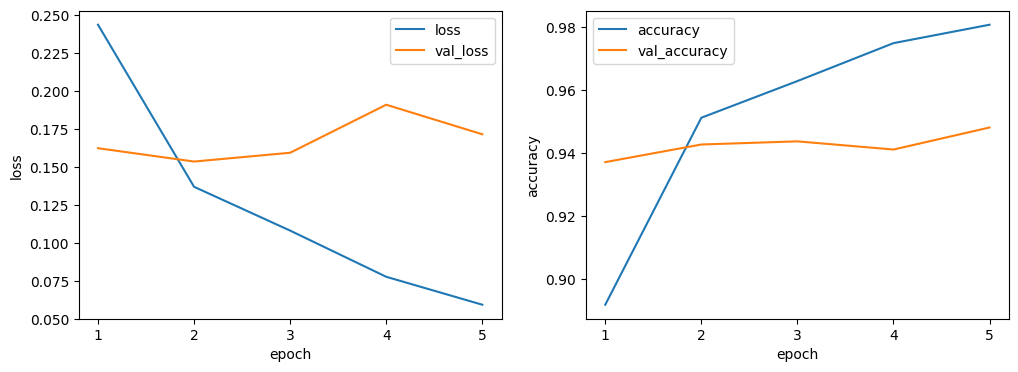

In [38]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.array(hist.epoch) + 1
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(epochs, hist.history['loss'], label='loss')
axs[0].plot(epochs, hist.history['val_loss'], label='val_loss')
axs[0].set_xticks(epochs)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(epochs, hist.history['sparse_categorical_accuracy'],
            label='accuracy')
axs[1].plot(epochs, hist.history['val_sparse_categorical_accuracy'],
            label='val_accuracy')
axs[1].set_xticks(epochs)
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.show()

In [39]:
roberta_classifier.evaluate(test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 68ms/step - loss: 0.1336 - sparse_categorical_accuracy: 0.9510


[0.13140769302845, 0.9522799849510193]

## DistilBERT

In [ ]:
# BERT 베이스 MLM
vocab_size = 30522
num_layers = 12
num_heads = 12
embed_dim = 768
dropout = 0.1
activation = 'gelu'
max_seq_len = 512

token_ids = keras.Input(shape=(None,))
segment_ids = keras.Input(shape=(None,))
padding_mask = keras.Input(shape=(None,))
mlm_position = keras.Input(shape=(None,))

token_embedding_layer = keras_nlp.layers.ReversibleEmbedding(vocab_size, embed_dim)
token_embedding = token_embedding_layer(token_ids)

pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)
seg_embedding = layers.Embedding(2, embed_dim)(segment_ids)

x = layers.Add()((token_embedding, pos_embedding, seg_embedding))
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout)(x)

for _ in range(num_layers):
    x = transformer_encoder(x, padding_mask, dropout, activation)

mlm_position = keras.ops.expand_dims(mlm_position, axis=-1)
x = keras.ops.take_along_axis(x, mlm_position, axis=1)

x = layers.Dense(embed_dim, activation='gelu')(x)
x = layers.LayerNormalization()(x)
outputs = token_embedding_layer(x, reverse=True)

model = keras.Model(inputs=(token_ids, segment_ids, padding_mask, mlm_position),
                    outputs=(outputs))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reversible_embedding      │ (None, None, 30522)    │     23,440,896 │ input_layer_2[1][0],   │
│ (ReversibleEmbedding)     │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ position_embedding_1      │ (None, None, 768)      │        393,216 │ reversible_embedding[… │
│ (PositionEmbedding)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 768)      │          1,536 │ input_layer_3[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_25 (Add)              │ (None, None, 768)      │              0 │ reversible_embedding[… │
│                           │                        │                │ position_embedding_1[… │
│                           │                        │                │ embedding_1[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_25    │ (None, None, 768)      │          1,536 │ add_25[1][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_49 (Dropout)      │ (None, None, 768)      │              0 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_12   │ (None, None, 768)      │      2,362,368 │ input_layer_4[1][0],   │
│ (MultiHeadAttention)      │                        │                │ dropout_49[1][0],      │
│                           │                        │                │ dropout_49[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_51 (Dropout)      │ (None, None, 768)      │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_26 (Add)              │ (None, None, 768)      │              0 │ dropout_51[1][0],      │
│                           │                        │                │ dropout_49[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_26    │ (None, None, 768)      │          1,536 │ add_26[1][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)     

 Total params: 109,483,776 (417.65 MB)

 Trainable params: 109,483,776 (417.65 MB)

 Non-trainable params: 0 (0.00 B)

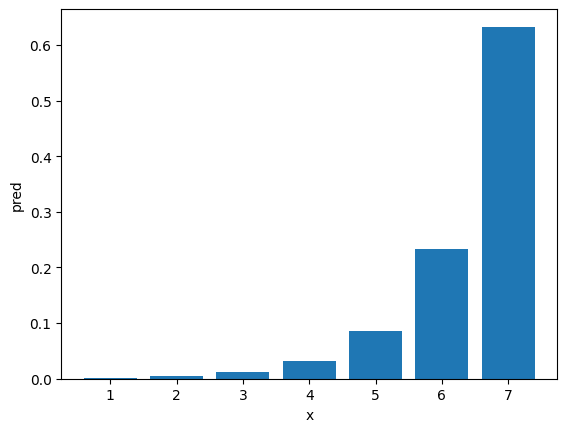

In [ ]:
from scipy.special import softmax

x = np.array([1, 2, 3, 4, 5, 6, 7])
pred = softmax(x)

plt.bar(x, pred)
plt.xlabel('x')
plt.ylabel('pred')
plt.show()

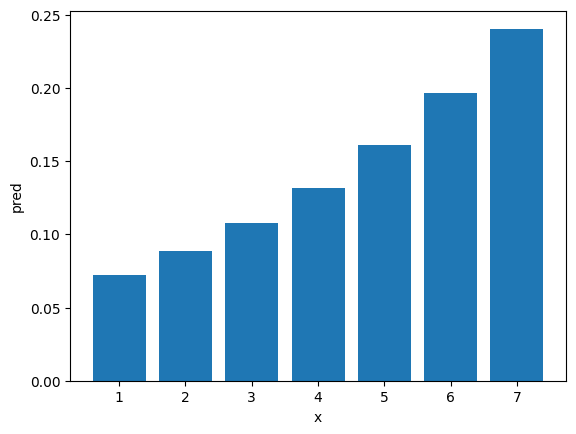

In [ ]:
pred = softmax(x/5)

plt.bar(x, pred)
plt.xlabel('x')
plt.ylabel('pred')
plt.show()

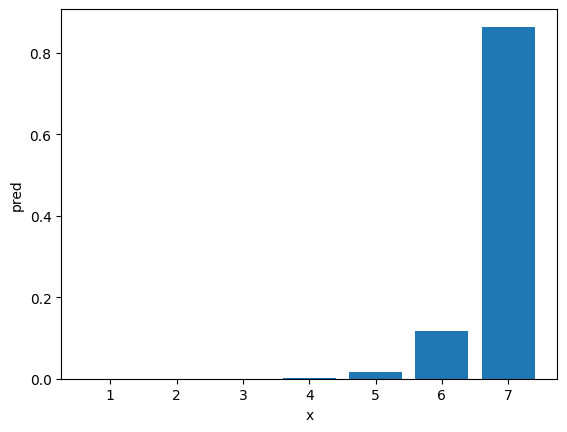

In [ ]:
pred = softmax(x/0.5)

plt.bar(x, pred)
plt.xlabel('x')
plt.ylabel('pred')
plt.show()

In [ ]:
distilbert_classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    'distil_bert_base_en_uncased',
    num_classes=2)
distilbert_classifier.summary()

100%|██████████| 140/140 [00:00<00:00, 184kB/s]


100%|██████████| 515/515 [00:00<00:00, 548kB/s]


100%|██████████| 253M/253M [00:02<00:00, 93.0MB/s]


100%|██████████| 580/580 [00:00<00:00, 1.50MB/s]


100%|██████████| 226k/226k [00:00<00:00, 2.09MB/s]


Preprocessor: "distil_bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline("fill-mask", device=0,
                model="distilbert/distilbert-base-uncased")
pipe('The goal of life is [MASK].')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

[{'score': 0.03619164600968361,
  'token': 8404,
  'token_str': 'happiness',
  'sequence': 'the goal of life is happiness.'},
 {'score': 0.030553525313735008,
  'token': 7691,
  'token_str': 'survival',
  'sequence': 'the goal of life is survival.'},
 {'score': 0.01697716861963272,
  'token': 12611,
  'token_str': 'salvation',
  'sequence': 'the goal of life is salvation.'},
 {'score': 0.0166984423995018,
  'token': 4071,
  'token_str': 'freedom',
  'sequence': 'the goal of life is freedom.'},
 {'score': 0.015267280861735344,
  'token': 8499,
  'token_str': 'unity',
  'sequence': 'the goal of life is unity.'}]

In [ ]:
pipe = pipeline(
    'text-classification', device=0,
    model='distilbert/distilbert-base-uncased-finetuned-sst-2-english'
    )
pipe('The movie is a bit boring and easy to guess')

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'NEGATIVE', 'score': 0.9997172951698303}]

아래 패키지를 설치한 후 세션을 다시 시작하세요.

In [1]:
!pip install datasets evaluate pyarrow==15.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 15.0.2 which is incompatible.


In [2]:
from transformers import pipeline

pipe = pipeline(
    'text-classification', device=0,
    model='distilbert/distilbert-base-uncased-finetuned-sst-2-english'
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [3]:
from datasets import load_dataset

ds = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [5]:
test_slice = ds['test'].shuffle(seed=42).select(range(1000))

In [6]:
from evaluate import evaluator

task_evaluator = evaluator("text-classification")
task_evaluator.compute(
    model_or_pipeline=pipe,
    data=test_slice,
    metric="accuracy",
    input_column="text",
    label_column="label",
    label_mapping={"NEGATIVE": 0, "POSITIVE": 1}
    )

{'accuracy': 0.881,
 'total_time_in_seconds': 8.194274674000098,
 'samples_per_second': 122.03642662515757,
 'latency_in_seconds': 0.008194274674000098}

In [7]:
task_evaluator.compute(
    model_or_pipeline='distilbert/distilbert-base-uncased-finetuned-sst-2-english',
    data=test_slice,
    device=0,
    label_mapping={"NEGATIVE": 0, "POSITIVE": 1}
    )

{'accuracy': 0.881,
 'total_time_in_seconds': 6.857453764999946,
 'samples_per_second': 145.82672144345227,
 'latency_in_seconds': 0.006857453764999945}

## 심화 예제

In [ ]:
# DistilBERT 백본
vocab_size = 30522
num_layers = 6
num_heads = 12
embed_dim = 768
dropout = 0.1
activation = 'gelu'
max_seq_len = 512

token_ids = keras.Input(shape=(None,))
padding_mask = keras.Input(shape=(None,))

token_embedding = layers.Embedding(vocab_size, embed_dim)(token_ids)
pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)

x = layers.Add()((token_embedding, pos_embedding))
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout)(x)

for _ in range(num_layers):
   x = transformer_encoder(x, padding_mask, dropout, activation)

outputs = x
distilbert_model = keras.Model(inputs=(token_ids, padding_mask),
                            outputs=(outputs))
distilbert_model.summary()

In [ ]:
distilbert_backbone = keras_nlp.models.DistilBertBackbone.from_preset(
    'distil_bert_base_en_uncased')
distilbert_backbone.summary()